In [1]:
import numpy as np
import pandas as pd
from textacy import text_stats, make_spacy_doc
from langdetect import detect, DetectorFactory
from scipy.stats import pointbiserialr
from scipy.stats import zscore, gmean
from datasets import Dataset, load_dataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import itertools
import torch
import os

In [2]:
df_sample = pd.DataFrame(load_dataset("argilla/ultrafeedback-binarized-preferences-cleaned")["train"]).sample(n=15000, random_state=42)
df_clean = df_sample.copy()

In [3]:
df_clean = df_clean.reset_index(drop=True)
df_clean

,source,prompt,chosen,chosen-rating,chosen-model,rejected,rejected-rating,rejected-model
0,sharegpt,Topics: Wound management for general practitio...,[{'content': 'Topics: Wound management for gen...,5.00,wizardlm-70b,[{'content': 'Topics: Wound management for gen...,3.75,ultralm-13b
1,flan_v2_niv2,"Part 1. Definition\nIn this task, you are give...","[{'content': 'Part 1. Definition In this task,...",4.50,wizardlm-70b,"[{'content': 'Part 1. Definition In this task,...",3.25,vicuna-33b
2,sharegpt,You will act as an voice changer. You will cha...,[{'content': 'You will act as an voice changer...,4.50,wizardlm-13b,[{'content': 'You will act as an voice changer...,1.75,ultralm-13b
3,ultrachat,Write a well-researched paper on the physiolog...,[{'content': 'Write a well-researched paper on...,4.75,wizardlm-13b,[{'content': 'Write a well-researched paper on...,3.00,ultralm-13b
4,ultrachat,Create a step-by-step recipe for making fluffy...,[{'content': 'Create a step-by-step recipe for...,5.00,llama-2-7b-chat,[{'content': 'Create a step-by-step recipe for...,4.50,falcon-40b-instruct
...,...,...,...,...,...,...,...,...
14995,flan_v2_cot,"[QUESTION] If ""Two kids stepping stones over t...","[{'content': '[QUESTION] If ""Two kids stepping...",4.75,gpt-3.5-turbo,"[{'content': '[QUESTION] If ""Two kids stepping...",1.75,llama-2-7b-chat
14996,flan_v2_niv2,"Instructions: Given an object and a part, deci...",[{'content': 'Instructions: Given an object an...,4.50,vicuna-33b,[{'content': 'Instructions: Given an object an...,3.50,llama-2-7b-chat
14997,sharegpt,Write me a letter asking my friend Dan what he...,[{'content': 'Write me a letter asking my frie...,4.50,ultralm-13b,[{'content': 'Write me a letter asking my frie...,1.25,llama-2-7b-chat
14998,flan_v2_niv2,You will be given a definition of a task first...,[{'content': 'You will be given a definition o...,2.00,llama-2-70b-chat,[{'content': 'You will be given a definition o...,1.00,vicuna-33b


In [4]:
df_clean['chosen'] = df_clean['chosen'].apply(lambda x: x[1]['content'])
df_clean['rejected'] = df_clean['rejected'].apply(lambda x: x[1]['content'])

## Need to bring in the docs to filter before organizing and running stats

In [5]:
topics = pd.read_csv("UF10k_mixedbread_topics.csv")
docs = pd.read_csv("UF_mixedbread_docs.csv")

In [6]:
#Cleaning
docs['topic_id'] = docs['topic_id'].str.extract(r'(\d+)').astype(int)

docs['x_cord'] = docs['x_cord'].str.extract(r'(\d+.\d+)').astype(float)
docs['y_cord'] = docs['y_cord'].str.extract(r'(\d+.\d+)').astype(float)

In [7]:
# Merging to get all the data in one place
docs_and_topics = docs.merge(topics.drop(columns=['doc_id', 'topic_id']), on='content')
docs_and_topics = docs_and_topics.drop(columns=['term_id', 'doc_id']).rename(columns={'10': 'metadata', 'content': 'prompt'})
df_clean = df_clean.merge(docs_and_topics, on='prompt')

In [8]:
df_clean

,source,prompt,chosen,chosen-rating,chosen-model,rejected,rejected-rating,rejected-model,x_cord,y_cord,topic_id,embeddings,metadata,topic_name
0,sharegpt,Topics: Wound management for general practitio...,General practitioners play a vital role in the...,5.00,wizardlm-70b,Wound management is a crucial aspect of genera...,3.75,ultralm-13b,0.915843,0.482842,22,"[0.20282909274101257, -0.05036671459674835, -0...","('metadata', {'source': 'sharegpt', 'rating': ...",Childhood Stress and Health
1,flan_v2_niv2,"Part 1. Definition\nIn this task, you are give...",Step 1: Identify the language of the post. The...,4.50,wizardlm-70b,Non-hateful\n\nExplanation: This post seems to...,3.25,vicuna-33b,2.740021,4.862818,14,"[0.06639007478952408, 0.23666216433048248, -0....","('metadata', {'source': 'flan_v2_niv2', 'ratin...",Analyzing Product Sentiment
2,sharegpt,You will act as an voice changer. You will cha...,An umbrella has been brought by her on the way.,4.50,wizardlm-13b,"Alright, just let me know which form of voice ...",1.75,ultralm-13b,2.045614,4.058925,15,"[-0.4921853840351105, -0.1649392992258072, -0....","('metadata', {'source': 'sharegpt', 'rating': ...",Language Analysis
3,ultrachat,Write a well-researched paper on the physiolog...,Title: The Physiological and Psychological Imp...,4.75,wizardlm-13b,Title: The Physiological and Psychological Imp...,3.00,ultralm-13b,1.698340,0.061782,8,"[-0.30388227105140686, 0.15756076574325562, 0....","('metadata', {'source': 'ultrachat', 'rating':...",Healthy Lifestyle Exploration
4,ultrachat,Create a step-by-step recipe for making fluffy...,"Of course, I'd be happy to help you with that!...",5.00,llama-2-7b-chat,Here is a step-by-step recipe for making fluff...,4.50,falcon-40b-instruct,3.702293,1.716949,6,"[-0.05435372143983841, 0.28580591082572937, -0...","('metadata', {'source': 'ultrachat', 'rating':...",Culinary Creations
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10203,sharegpt,Transform is an emerging brand that delivers m...,"Welcome to Transform, your go-to source for in...",4.75,gpt-3.5-turbo,"Sure, here's a possible description for the ""A...",4.00,llama-2-70b-chat,0.732869,1.959356,21,"[-0.4771421253681183, -0.0352528840303421, -0....","('metadata', {'source': 'sharegpt', 'rating': ...",Marketing Strategy Platform
10204,evol_instruct,"Using Python and the scikit-learn library, how...",Detecting sarcasm in text is a challenging tas...,4.75,wizardlm-13b,"Hello! As a helpful and respectful assistant, ...",4.00,llama-2-13b-chat,2.532706,5.040441,14,"[0.3401801884174347, 0.21816378831863403, 0.02...","('metadata', {'source': 'evol_instruct', 'rati...",Analyzing Product Sentiment
10205,flan_v2_cot,"[QUESTION] If ""Two kids stepping stones over t...","Yes, the premise mentions pink plaid pants and...",4.75,gpt-3.5-turbo,Confidence: 80%\n\nYou have provided several s...,1.75,llama-2-7b-chat,3.797116,0.511288,18,"[0.39390242099761963, 0.10773289203643799, -0....","('metadata', {'source': 'flan_v2_cot', 'rating...",Gender and Clothing Perceptions
10206,sharegpt,Write me a letter asking my friend Dan what he...,"Dear Dan,\n\nWe hope this letter finds you wel...",4.50,ultralm-13b,I cannot fulfill your request as it goes again...,1.25,llama-2-7b-chat,0.873350,3.242940,1,"[0.7983337640762329, -0.37210243940353394, 0.5...","('metadata', {'source': 'sharegpt', 'rating': ...",Cultural Expression


## Now we need put all the responses together, regradless of whether they are rejected or accepted

In [9]:
df_reject = df_clean.iloc[:, [0 , 1, 5, 6, 7]]
df_accept = df_clean.iloc[:, [0, 1, 2, 3, 4]]

In [10]:
df_reject = df_reject.rename(columns={'rejected' : 'response', 'rejected-rating' : 'rating', 'rejected-model' : 'model'})
df_reject['chosen'] = 0
df_accept = df_accept.rename(columns={'chosen' : 'response', 'chosen-rating': 'rating', 'chosen-model' : 'model'})
df_accept['chosen'] = 1

In [11]:
frames = [df_accept, df_reject]

#put them all together

df_all = pd.concat(frames)
df_all

,source,prompt,response,rating,model,chosen
0,sharegpt,Topics: Wound management for general practitio...,General practitioners play a vital role in the...,5.00,wizardlm-70b,1
1,flan_v2_niv2,"Part 1. Definition\nIn this task, you are give...",Step 1: Identify the language of the post. The...,4.50,wizardlm-70b,1
2,sharegpt,You will act as an voice changer. You will cha...,An umbrella has been brought by her on the way.,4.50,wizardlm-13b,1
3,ultrachat,Write a well-researched paper on the physiolog...,Title: The Physiological and Psychological Imp...,4.75,wizardlm-13b,1
4,ultrachat,Create a step-by-step recipe for making fluffy...,"Of course, I'd be happy to help you with that!...",5.00,llama-2-7b-chat,1
...,...,...,...,...,...,...
10203,sharegpt,Transform is an emerging brand that delivers m...,"Sure, here's a possible description for the ""A...",4.00,llama-2-70b-chat,0
10204,evol_instruct,"Using Python and the scikit-learn library, how...","Hello! As a helpful and respectful assistant, ...",4.00,llama-2-13b-chat,0
10205,flan_v2_cot,"[QUESTION] If ""Two kids stepping stones over t...",Confidence: 80%\n\nYou have provided several s...,1.75,llama-2-7b-chat,0
10206,sharegpt,Write me a letter asking my friend Dan what he...,I cannot fulfill your request as it goes again...,1.25,llama-2-7b-chat,0


In [12]:
# Putting metadata back in:
df_all = df_all.merge(df_clean.loc[:, ['prompt', 'x_cord', 'y_cord','topic_id', 'embeddings', 'metadata', 'topic_name']], on='prompt')

In [13]:
# mix them up 
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)

### Lets Run a langdetect loop to see if anything is still not in english

In [14]:
#Since we have to keep the pairs together, we need to index by prompt
DetectorFactory.seed = 0

non_english_prompts = []
non_parasable_prompts = []

for index, row in df_all.iterrows():
    try:
        if detect(row['response']) != 'en':
            non_english_prompts.append(row['prompt'])
    except:
        non_parasable_prompts.append(row['prompt'])

unusable_prompts = non_english_prompts + non_parasable_prompts

In [15]:
df_all = df_all[~df_all['prompt'].isin(unusable_prompts)]

In [15]:
#for some reason these rows don't work, idk why. Your dataset might not run in to this issue
# bads = [5230, 19157]

# df_all = df_all.drop(bads)

## Getting statistics form each of the responses

In [16]:
#Get text statisitsics for each response 

# NB! This takes forever to run so try to run it only once

for i, row in df_all.iterrows():
    #Make each into a SpaCy doc

    response = make_spacy_doc(row['response'], lang='en_core_web_sm')
    
    #Basics

    df_all.loc[i, 'n_sents'] = text_stats.basics.n_sents(response)

    df_all.loc[i, 'n_words'] = text_stats.basics.n_words(response)

    df_all.loc[i, 'n_uniquewords'] = text_stats.basics.n_unique_words(response)

    df_all.loc[i, 'n_chars'] = text_stats.basics.n_chars(response)

    df_all.loc[i, 'n_longwords'] = text_stats.basics.n_long_words(response)

    df_all.loc[i, 'n_sylsprword'] = text_stats.basics.n_syllables(response)

    df_all.loc[i, 'n_monosylwords'] = text_stats.basics.n_monosyllable_words(response)

    df_all.loc[i, 'n_polysylwords'] = text_stats.basics.n_polysyllable_words(response)

    df_all.loc[i, 'entropy'] = text_stats.basics.entropy(response)

    #Lexical Diversity

    df_all.loc[i, 'ttr'] = text_stats.diversity.ttr(response)

    df_all.loc[i, 'log_ttr'] = text_stats.diversity.log_ttr(response)

    df_all.loc[i, 'seg_ttr'] = text_stats.diversity.segmented_ttr(response)

    df_all.loc[i, 'mtld'] = text_stats.diversity.mtld(response)

    df_all.loc[i, 'hdd'] = text_stats.diversity.hdd(response)
    
    #Readability

    df_all.loc[i, 'flesch_score'] = text_stats.readability.flesch_reading_ease(response) 

    df_all.loc[i, 'flesch_grade'] = text_stats.readability.flesch_kincaid_grade_level(response)

    df_all.loc[i, 'gunning_fog'] = text_stats.readability.gunning_fog_index(response) 

    df_all.loc[i, 'coleman_liau'] = text_stats.readability.coleman_liau_index(response) 

    df_all.loc[i, 'automated_readability'] = text_stats.readability.automated_readability_index(response)


In [77]:
# df_checkpoint  = df_all.copy()

In [41]:
# df_all = df_checkpoint

In [17]:
#reordering for easier indexing
cols = df_all.columns.tolist()
cols = ['source',
 'prompt',
 'response',
 'model',
 'chosen',
 'rating',
 'n_sents',
 'n_words',
 'n_uniquewords',
 'n_chars',
 'n_longwords',
 'n_sylsprword',
 'n_monosylwords',
 'n_polysylwords',
 'entropy',
 'ttr',
 'log_ttr',
 'seg_ttr',
 'mtld',
 'hdd',
 'flesch_score',
 'flesch_grade',
 'gunning_fog',
 'coleman_liau',
 'automated_readability',
 'x_cord',
 'y_cord',
 'topic_id',
 'embeddings',
 'metadata',
 'topic_name']

df_all = df_all[cols]

In [2]:
# df_all.to_csv("Accepted_Rejected_with_scores.csv")

df_all = pd.read_csv("Accepted_Rejected_with_scores_bkup.csv", index_col = 0)

df_all

,source,prompt,response,model,chosen,rating,n_sents,n_words,n_uniquewords,n_chars,...,flesch_grade,gunning_fog,coleman_liau,automated_readability,x_cord,y_cord,topic_id,embeddings,metadata,topic_name
0,evol_instruct,Which word does not belong in the following gr...,Kettle does not belong in the group as it is a...,wizardlm-70b,0,4.50,1.0,25.0,24.0,96.0,...,7.848000,10.000000,5.594333,9.156400,2.294071,3.214199,15,"[-0.6554288864135742, -0.4138864278793335, 0.5...","('metadata', {'source': 'evol_instruct', 'rati...",Language Analysis
1,ultrachat,In what ways has technology changed the way in...,I do not have personal views or opinions. howe...,ultralm-65b,0,4.25,13.0,259.0,141.0,1338.0,...,10.358378,13.529076,13.089567,12.863508,2.254160,2.922242,1,"[-0.4531969428062439, 0.3193971812725067, 0.02...","('metadata', {'source': 'ultrachat', 'rating':...",Cultural Expression
2,flan_v2_niv2,Detailed Instructions: In this task you are gi...,Pangaea and Gondwana were two supercontinents ...,llama-2-70b-chat,0,3.25,5.0,97.0,56.0,517.0,...,10.345072,13.120825,14.013078,13.373814,0.154498,1.925598,7,"[1.273107647895813, 0.08621750771999359, -0.16...","('metadata', {'source': 'flan_v2_niv2', 'ratin...",Interconnected Systems
3,ultrachat,What are the best snorkeling spots in Hawaii?,Hawaii is famous for its breathtaking underwat...,gpt-4,1,5.00,25.0,403.0,183.0,2034.0,...,8.235758,10.616734,12.040226,10.402060,2.054862,1.508557,16,"[-0.35886409878730774, 1.3211461305618286, -0....","('metadata', {'source': 'ultrachat', 'rating':...",Urban Exploration
4,false_qa,Why do anaerobic bacteria prefer an environmen...,Anaerobic bacteria do not prefer an environmen...,mpt-30b-chat,1,4.50,4.0,79.0,52.0,386.0,...,10.634019,14.482278,11.430504,11.458418,0.146003,0.876940,7,"[0.5538246631622314, 0.7116502523422241, -0.06...","('metadata', {'source': 'false_qa', 'rating': ...",Interconnected Systems
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20410,flan_v2_niv2,"Detailed Instructions: In this task, you are g...",user\n\nExplanation: The user is asking for mo...,mpt-30b-chat,1,4.50,3.0,36.0,29.0,207.0,...,9.084444,12.577778,15.542733,11.652500,0.720507,2.482977,1,"[0.3781099021434784, 0.03334461525082588, -0.3...","('metadata', {'source': 'flan_v2_niv2', 'ratin...",Cultural Expression
20412,evol_instruct,How can I modify the existing C# code to also ...,To modify the existing code to calculate the e...,wizardlm-70b,0,4.00,14.0,390.0,150.0,2122.0,...,15.183004,19.142857,15.129509,18.125802,2.395390,0.070725,19,"[-0.05869555473327637, 0.5773212313652039, -0....","('metadata', {'source': 'evol_instruct', 'rati...",Gaming Economics
20413,flan_v2_niv2,Find the movie name from the given conversatio...,The Lion King,gpt-4,1,4.50,1.0,3.0,3.0,11.0,...,1.313333,1.200000,-4.103777,-2.660000,0.030586,3.049329,5,"[0.7883694767951965, -0.3784785866737366, 0.16...","('metadata', {'source': 'flan_v2_niv2', 'ratin...",Movie Analysis and Interpretation
20414,sharegpt,"Create a slack conversation between 4 people, ...",Thread 1: 🎯 Sales Strategies\n\nMonika: Hey gu...,wizardlm-13b,1,5.00,29.0,361.0,201.0,1705.0,...,6.000562,9.300640,9.592866,7.039429,0.281950,2.280695,21,"[1.0214362144470215, -0.0009904910111799836, -...","('metadata', {'source': 'sharegpt', 'rating': ...",Marketing Strategy Platform


In [3]:
stats_only = df_all.iloc[:, 4:-6]

## Indicators of high score

In [4]:
from scipy.stats import pearsonr

In [5]:
stats_only.iloc[:, :22]

,chosen,rating,n_sents,n_words,n_uniquewords,n_chars,n_longwords,n_sylsprword,n_monosylwords,n_polysylwords,...,ttr,log_ttr,seg_ttr,mtld,hdd,flesch_score,flesch_grade,gunning_fog,coleman_liau,automated_readability
0,0,4.50,1.0,25.0,24.0,96.0,1.0,29.0,21.0,0.0,...,0.960000,0.987318,0.960000,1.749988e+02,0.960000,83.324000,7.848000,10.000000,5.594333,9.156400
1,0,4.25,13.0,259.0,141.0,1338.0,74.0,399.0,162.0,36.0,...,0.544402,0.890573,0.812000,8.796028e+01,0.837401,56.283347,10.358378,13.529076,13.089567,12.863508
2,0,3.25,5.0,97.0,56.0,517.0,26.0,151.0,66.0,13.0,...,0.577320,0.879914,0.680000,6.493267e+01,0.763649,55.447093,10.345072,13.120825,14.013078,13.373814
3,1,5.00,25.0,403.0,183.0,2034.0,111.0,599.0,263.0,42.0,...,0.454094,0.868402,0.855000,9.404830e+01,0.845886,64.727791,8.235758,10.616734,12.040226,10.402060
4,1,4.50,4.0,79.0,52.0,386.0,20.0,124.0,50.0,13.0,...,0.658228,0.904289,0.700000,4.386836e+01,0.751405,53.998877,10.634019,14.482278,11.430504,11.458418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20410,1,4.50,3.0,36.0,29.0,207.0,12.0,61.0,24.0,7.0,...,0.805556,0.939662,0.805556,5.183993e+01,0.805556,51.305000,9.084444,12.577778,15.542733,11.652500
20412,0,4.00,14.0,390.0,150.0,2122.0,109.0,658.0,251.0,78.0,...,0.384615,0.839844,0.731429,4.799145e+01,0.789403,35.824615,15.183004,19.142857,15.129509,18.125802
20413,1,4.50,1.0,3.0,3.0,11.0,0.0,4.0,2.0,0.0,...,1.000000,1.000000,1.000000,3.000000e+06,1.000000,90.990000,1.313333,1.200000,-4.103777,-2.660000
20414,1,5.00,29.0,361.0,201.0,1705.0,85.0,512.0,261.0,39.0,...,0.556787,0.900563,0.865714,1.265851e+02,0.871082,74.213296,6.000562,9.300640,9.592866,7.039429


## Indicators of High Score

In [6]:
results = {}
continuous_vars = stats_only.columns[2:22]
regressor = stats_only.columns[1]

index = pd.MultiIndex.from_product([continuous_vars])
score_corr_df = pd.DataFrame(index=continuous_vars, columns=[regressor, 'p_value'])

for index in continuous_vars:
    corr = pearsonr(stats_only[index], stats_only['rating'])[0]
    pval = round(pearsonr(stats_only[index], stats_only['rating'])[1], 7)
    score_corr_df['rating'][index] = corr
    score_corr_df['p_value'][index] = pval
    
score_corr_df.rename(columns={'rating': 'pearson_r'}, inplace=True)
score_corr_df = score_corr_df.apply(pd.to_numeric)
score_corr_df
score_corr_df.sort_values(by='pearson_r', ascending=False)
score_corr_df

/tmp/ipykernel_290969/251589786.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  score_corr_df['rating'][index] = corr
/tmp/ipykernel_290969/251589786.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You

,pearson_r,p_value
n_sents,0.321838,0.000000
n_words,0.345331,0.000000
n_uniquewords,0.374831,0.000000
n_chars,0.359418,0.000000
n_longwords,0.358820,0.000000
n_sylsprword,0.356477,0.000000
n_monosylwords,0.315947,0.000000
n_polysylwords,0.341162,0.000000
entropy,0.338554,0.000000
ttr,-0.261976,0.000000


## Indicators of 'Accepted'

In [7]:
results = {}
continuous_vars = stats_only.columns[1:]
dummy_vars = [stats_only.columns[0]]

index = pd.MultiIndex.from_product([continuous_vars])

corr_df = pd.DataFrame(index=continuous_vars, columns=dummy_vars)

for dummy in dummy_vars:
    for continuous in continuous_vars:
        corr, p_value = pointbiserialr(stats_only[continuous], stats_only[dummy])
        results[f'{continuous} & {dummy}'] = (corr, p_value)
        corr_df.loc[continuous, dummy] = corr
        

corr_df = corr_df.apply(pd.to_numeric)

pvalues = []
for i in results.values():
    pvalues.append((i[1]))

corr_df['p_values'] = pvalues

corr_df = corr_df.rename(columns={'chosen': 'PB_Correlation'})

In [8]:
# Need a standardized way of assesing variance of metrics

def coefficient_of_variation(series):
    return series.std() / series.mean()

cv = stats_only.iloc[:, 1:].apply(coefficient_of_variation)

corr_df['coef_of_variation'] = cv

In [9]:
corr_df.sort_values(by=['PB_Correlation', 'coef_of_variation', 'p_values'], ascending=[False, False, True])

,PB_Correlation,p_values,coef_of_variation
rating,0.614129,0.000000e+00,0.234076
n_uniquewords,0.196736,2.747041e-162,0.697326
n_longwords,0.187078,1.157878e-146,0.949104
n_chars,0.186004,5.608548e-145,0.857868
n_sylsprword,0.183760,1.729277e-141,0.856042
n_polysylwords,0.177103,2.090408e-131,1.061894
n_words,0.176389,2.387506e-130,0.820856
n_sents,0.167302,2.809735e-117,0.904568
n_monosylwords,0.159521,1.154379e-106,0.812866
entropy,0.150920,1.507789e-95,0.212756


## Statistically Significant metrics for 'Accepted' 

In [10]:
corr_df[corr_df['p_values'] <= 0.05].sort_values(by=['PB_Correlation', 'coef_of_variation'], ascending=[False, False])

,PB_Correlation,p_values,coef_of_variation
rating,0.614129,0.000000e+00,0.234076
n_uniquewords,0.196736,2.747041e-162,0.697326
n_longwords,0.187078,1.157878e-146,0.949104
n_chars,0.186004,5.608548e-145,0.857868
n_sylsprword,0.183760,1.729277e-141,0.856042
n_polysylwords,0.177103,2.090408e-131,1.061894
n_words,0.176389,2.387506e-130,0.820856
n_sents,0.167302,2.809735e-117,0.904568
n_monosylwords,0.159521,1.154379e-106,0.812866
entropy,0.150920,1.507789e-95,0.212756


## n_unique words

In [46]:
df_unique_words = df_clean[df_clean['prompt'].isin(df_all['prompt'])]

In [47]:
df_unique_words['n_unique_words_accepted'] = None
df_unique_words['n_unique_words_rejected'] = None

/tmp/ipykernel_2110413/1875626631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_words['n_unique_words_accepted'] = None
/tmp/ipykernel_2110413/1875626631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_words['n_unique_words_rejected'] = None


In [52]:
df_unique_words.reset_index(drop=True, inplace=True)

In [53]:
chosen_subset = df_all[df_all['chosen'] == 1]
rejected_subset = df_all[df_all['chosen'] == 0]

In [54]:
nuwords_chosen_response_metric_pairs = pd.DataFrame({'response': chosen_subset.loc[:, 'response'], 'score': chosen_subset.loc[:, 'n_uniquewords']}).reset_index(drop=True)
nuwords_rejected_response_metric_pairs = pd.DataFrame({'response': rejected_subset.loc[:, 'response'], 'score': rejected_subset.loc[:, 'n_uniquewords']}).reset_index(drop=True)

for i in range(len(df_unique_words)):
    df_unique_words.iloc[i, df_unique_words.columns.get_loc('n_unique_words_accepted')] = nuwords_chosen_response_metric_pairs.iloc[np.where(nuwords_chosen_response_metric_pairs['response'] == df_unique_words['chosen'][i])[0][0], -1]
    df_unique_words.iloc[i, df_unique_words.columns.get_loc('n_unique_words_rejected')] = nuwords_rejected_response_metric_pairs.iloc[np.where(nuwords_rejected_response_metric_pairs['response'] == df_unique_words['rejected'][i])[0][0], -1]



In [56]:
df_unique_words.to_csv('unique_words_sample.csv')

# Making the metric

## Standardizing units

In [35]:
# Getting the z-score for all the metrics. 
for col in stats_only.columns:
    df_all.loc[:, col + '_z_score'] = zscore(df_all.loc[:, col])


z_score_cols = df_all.columns[32: ]
relevant_z_scores = ['n_uniquewords_z_score', 'n_longwords_z_score', 'n_chars_z_score', 'n_sylsprword_z_score', 
                     'n_polysylwords_z_score', 'n_words_z_score', 'n_sents_z_score', 'n_monosylwords_z_score',
                     'entropy_z_score', 'coleman_liau_z_score', 'automated_readability_z_score', 'flesch_grade_z_score', 'gunning_fog_z_score']

# df_all.to_csv("Accepted_Rejected_with_scores.csv")

In [ ]:
#I don't think I need this anymore

# NB! You need to remove these two rows because they throw an error when you try to match them with a score, because they are the ones we took out when converting to spacy doc, since spacy cannot convert empty strings. I probably should have done this earlier but oh well. They are found by running the loops below
# df_clean = df_clean.drop([2776, 3482]).reset_index(drop=True)

# for i in range(len(df_clean)):
#     try:
#         x = np.where(chosen_response_metric_pairs['response'] == df_clean['chosen'][i])[0][0]
#     except:
#         print(i)

# for i in range(len(df_clean)):
#     try:
#         x = np.where(rejected_response_metric_pairs['response'] == df_clean['rejected'][i])[0][0]
#     except:
#         print(i)


## Linear Metric

In [36]:
df_all.loc[:, 'linear_metric'] = df_all.loc[:, relevant_z_scores].sum(axis=1)

In [37]:
# make a copy for editing
df_linear = df_clean[df_clean['prompt'].isin(df_all['prompt'])]

In [38]:
chosen_subset = df_all[df_all['chosen'] == 1]
rejected_subset = df_all[df_all['chosen'] == 0]

Linear_chosen_response_metric_pairs = pd.DataFrame({'response': chosen_subset.loc[:, 'response'], 'score': chosen_subset.loc[:, 'linear_metric']}).reset_index(drop=True)
Linear_rejected_response_metric_pairs = pd.DataFrame({'response': rejected_subset.loc[:, 'response'], 'score': rejected_subset.loc[:, 'linear_metric']}).reset_index(drop=True)

#Let's check out the stats on the metric real quick:
Linear_metric_distribution = pd.DataFrame({'Group': ['Accepted', 'Rejected'], 
                        'Mean' : [Linear_chosen_response_metric_pairs['score'].mean(), Linear_rejected_response_metric_pairs['score'].mean()], 
                        'Standard Deviaton': [np.std(Linear_chosen_response_metric_pairs['score']), np.std(Linear_rejected_response_metric_pairs['score'])],
                        'Variance': [np.var(Linear_chosen_response_metric_pairs['score']), np.var(Linear_rejected_response_metric_pairs['score'])],
                        'Max': [Linear_chosen_response_metric_pairs['score'].max(), Linear_rejected_response_metric_pairs['score'].max()],
                        'Min': [Linear_chosen_response_metric_pairs['score'].min(), Linear_rejected_response_metric_pairs['score'].min()]}) 

Linear_metric_distribution

,Group,Mean,Standard Deviaton,Variance,Max,Min
0,Accepted,1.748692,10.409601,108.359788,51.401732,-32.810444
1,Rejected,-1.748692,9.462044,89.530281,131.373559,-32.810444


Now let's add the metrics in

In [39]:
# initialize columns
df_linear = df_linear.reset_index(drop=True)
df_linear['accepted_linear_metric'] = None
df_linear['rejected_linear_metric'] = None

#cycle through the subsets to get the scores and match them to their respective rows given the pairs in df_clean
for i in range(len(df_linear)):
    df_linear.iloc[i, df_linear.columns.get_loc('accepted_linear_metric')]= Linear_chosen_response_metric_pairs.iloc[np.where(Linear_chosen_response_metric_pairs['response'] == df_linear['chosen'][i])[0][0], -1]
    df_linear.iloc[i, df_linear.columns.get_loc('rejected_linear_metric')] = Linear_rejected_response_metric_pairs.iloc[np.where(Linear_rejected_response_metric_pairs['response'] == df_linear['rejected'][i])[0][0], -1]

df_linear['diff_linear_metric'] = df_linear['accepted_linear_metric'] - df_linear['rejected_linear_metric']
df_linear.to_csv("linear_metric_df.csv")

In [40]:
df_linear

,source,prompt,chosen,chosen-rating,chosen-model,rejected,rejected-rating,rejected-model,x_cord,y_cord,topic_id,embeddings,metadata,topic_name,accepted_linear_metric,rejected_linear_metric,diff_linear_metric
0,sharegpt,Topics: Wound management for general practitio...,General practitioners play a vital role in the...,5.00,wizardlm-70b,Wound management is a crucial aspect of genera...,3.75,ultralm-13b,0.915843,0.482842,22,"[0.20282909274101257, -0.05036671459674835, -0...","('metadata', {'source': 'sharegpt', 'rating': ...",Childhood Stress and Health,16.129277,-0.869996,16.999273
1,flan_v2_niv2,"Part 1. Definition\nIn this task, you are give...",Step 1: Identify the language of the post. The...,4.50,wizardlm-70b,Non-hateful\n\nExplanation: This post seems to...,3.25,vicuna-33b,2.740021,4.862818,14,"[0.06639007478952408, 0.23666216433048248, -0....","('metadata', {'source': 'flan_v2_niv2', 'ratin...",Analyzing Product Sentiment,-7.417868,-5.87031,-1.547558
2,sharegpt,You will act as an voice changer. You will cha...,An umbrella has been brought by her on the way.,4.50,wizardlm-13b,"Alright, just let me know which form of voice ...",1.75,ultralm-13b,2.045614,4.058925,15,"[-0.4921853840351105, -0.1649392992258072, -0....","('metadata', {'source': 'sharegpt', 'rating': ...",Language Analysis,-17.180493,-11.351724,-5.82877
3,ultrachat,Write a well-researched paper on the physiolog...,Title: The Physiological and Psychological Imp...,4.75,wizardlm-13b,Title: The Physiological and Psychological Imp...,3.00,ultralm-13b,1.698340,0.061782,8,"[-0.30388227105140686, 0.15756076574325562, 0....","('metadata', {'source': 'ultrachat', 'rating':...",Healthy Lifestyle Exploration,23.249564,1.21647,22.033094
4,ultrachat,Create a step-by-step recipe for making fluffy...,"Of course, I'd be happy to help you with that!...",5.00,llama-2-7b-chat,Here is a step-by-step recipe for making fluff...,4.50,falcon-40b-instruct,3.702293,1.716949,6,"[-0.05435372143983841, 0.28580591082572937, -0...","('metadata', {'source': 'ultrachat', 'rating':...",Culinary Creations,4.427499,8.015921,-3.588422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9333,sharegpt,Transform is an emerging brand that delivers m...,"Welcome to Transform, your go-to source for in...",4.75,gpt-3.5-turbo,"Sure, here's a possible description for the ""A...",4.00,llama-2-70b-chat,0.732869,1.959356,21,"[-0.4771421253681183, -0.0352528840303421, -0....","('metadata', {'source': 'sharegpt', 'rating': ...",Marketing Strategy Platform,-2.682148,-0.578695,-2.103454
9334,evol_instruct,"Using Python and the scikit-learn library, how...",Detecting sarcasm in text is a challenging tas...,4.75,wizardlm-13b,"Hello! As a helpful and respectful assistant, ...",4.00,llama-2-13b-chat,2.532706,5.040441,14,"[0.3401801884174347, 0.21816378831863403, 0.02...","('metadata', {'source': 'evol_instruct', 'rati...",Analyzing Product Sentiment,14.92361,20.216777,-5.293167
9335,flan_v2_cot,"[QUESTION] If ""Two kids stepping stones over t...","Yes, the premise mentions pink plaid pants and...",4.75,gpt-3.5-turbo,Confidence: 80%\n\nYou have provided several s...,1.75,llama-2-7b-chat,3.797116,0.511288,18,"[0.39390242099761963, 0.10773289203643799, -0....","('metadata', {'source': 'flan_v2_cot', 'rating...",Gender and Clothing Perceptions,-10.996563,-8.51755,-2.479013
9336,sharegpt,Write me a letter asking my friend Dan what he...,"Dear Dan,\n\nWe hope this letter finds you wel...",4.50,ultralm-13b,I cannot fulfill your request as it goes again...,1.25,llama-2-7b-chat,0.873350,3.242940,1,"[0.7983337640762329, -0.37210243940353394, 0.5...","('metadata', {'source': 'sharegpt', 'rating': ...",Cultural Expression,2.011627,-0.78087,2.792497


## Geometric Mean - actually can't do this because there are negative numbers in the dataset

In [43]:
df_gmean_linear = df_clean[df_clean['prompt'].isin(df_all['prompt'])].reset_index(drop=True)
df_gmean_linear['accepted_gmean'] = None # add some constant to all the values to get the negatives out of there.
df_gmean_linear['rejected_gmean'] = None

In [242]:
# gmeans = gmean(df_all.loc[:, relevant_z_scores])

In [243]:
# gmeans

array([0.36082393, 0.33315898, 0.36894024, 0.36676704, 0.30441279,
       0.37709697, 0.32685727, 0.3550817 , 0.21994893, 0.06290751,
       0.10475022, 0.17203504, 0.15986658])

In [226]:
chosen_subset = df_all[df_all['chosen'] == 1]
rejected_subset = df_all[df_all['chosen'] == 0]

gmean_chosen_response_metric_pairs = pd.DataFrame({'response': chosen_subset.loc[:, 'response'], 'score': chosen_subset.loc[:, 'Gmean']}).reset_index(drop=True)
gmean_rejected_response_metric_pairs = pd.DataFrame({'response': rejected_subset.loc[:, 'response'], 'score': rejected_subset.loc[:, 'Gmean']}).reset_index(drop=True)

#Let's check out the stats on the metric real quick:
gmean_metric_distribution = pd.DataFrame({'Group': ['Accepted', 'Rejected'], 
                        'Mean' : [Linear_chosen_response_metric_pairs['score'].mean(), Linear_rejected_response_metric_pairs['score'].mean()], 
                        'Standard Deviaton': [np.std(Linear_chosen_response_metric_pairs['score']), np.std(Linear_rejected_response_metric_pairs['score'])],
                        'Variance': [np.var(Linear_chosen_response_metric_pairs['score']), np.var(Linear_rejected_response_metric_pairs['score'])],
                        'Max': [Linear_chosen_response_metric_pairs['score'].max(), Linear_rejected_response_metric_pairs['score'].max()],
                        'Min': [Linear_chosen_response_metric_pairs['score'].min(), Linear_rejected_response_metric_pairs['score'].min()]}) 

gmean_metric_distribution

1.0000000000000004

## PCA Metric

In [51]:
df_pca = df_clean[df_clean['prompt'].isin(df_all['prompt'])].reset_index(drop=True)

Text(0.5, 1.0, 'PCA Explained Variance')

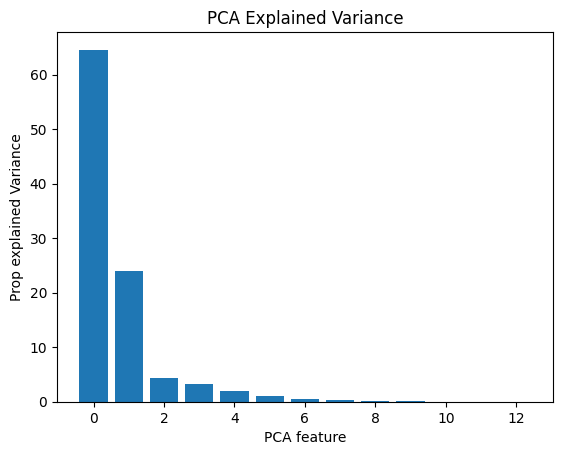

In [52]:
pca = PCA()

pca.fit(df_all[relevant_z_scores])
features = range(pca.n_components_)
fig, ax = plt.subplots()

ax.bar(features, pca.explained_variance_ratio_ * 100)
ax.set_xlabel("PCA feature")
ax.set_ylabel("Prop explained Variance")
ax.set_title("PCA Explained Variance")

In [53]:
pca_components = pca.fit_transform(df_all[relevant_z_scores])
fpc = pca_components[:, 0]

df_all.loc[:, 'PCA1'] = fpc

In [54]:
chosen_subset = df_all[df_all['chosen'] == 1]
rejected_subset = df_all[df_all['chosen'] == 0]

PCA_chosen_response_metric_pairs = pd.DataFrame({'response': chosen_subset.loc[:, 'response'], 'score': chosen_subset.loc[:, 'PCA1']}).reset_index(drop=True)
PCA_rejected_response_metric_pairs = pd.DataFrame({'response': rejected_subset.loc[:, 'response'], 'score': rejected_subset.loc[:, 'PCA1']}).reset_index(drop=True)

#Let's check out the stats on the metric real quick:
PCA_metric_distribution = pd.DataFrame({'Group': ['Accepted', 'Rejected'], 
                        'Mean' : [PCA_chosen_response_metric_pairs['score'].mean(), PCA_rejected_response_metric_pairs['score'].mean()], 
                        'Standard Deviaton': [np.std(PCA_chosen_response_metric_pairs['score']), np.std(PCA_rejected_response_metric_pairs['score'])],
                        'Variance': [np.var(PCA_chosen_response_metric_pairs['score']), np.var(PCA_rejected_response_metric_pairs['score'])],
                        'Max': [PCA_chosen_response_metric_pairs['score'].max(), PCA_rejected_response_metric_pairs['score'].max()],
                        'Min': [PCA_chosen_response_metric_pairs['score'].min(), PCA_rejected_response_metric_pairs['score'].min()]}) 

PCA_metric_distribution

,Group,Mean,Standard Deviaton,Variance,Max,Min
0,Accepted,0.532449,3.030683,9.185040,10.560854,-7.014653
1,Rejected,-0.532449,2.651317,7.029483,19.709713,-7.014653


In [55]:
df_pca['accepted_pca1'] = None
df_pca['rejected_pca1'] = None

for i in range(len(df_pca)):
    df_pca.iloc[i, df_pca.columns.get_loc('accepted_pca1')]= PCA_chosen_response_metric_pairs.iloc[np.where(PCA_chosen_response_metric_pairs['response'] == df_pca['chosen'][i])[0][0], -1]
    df_pca.iloc[i, df_pca.columns.get_loc('rejected_pca1')] = PCA_rejected_response_metric_pairs.iloc[np.where(PCA_rejected_response_metric_pairs['response'] == df_pca['rejected'][i])[0][0], -1]

df_pca['diff_pca1'] = df_pca['accepted_pca1'] - df_pca['rejected_pca1']

In [56]:
df_pca.to_csv("pca_metric_df.csv")

# Weighted PCA 

Might as well do a weighted Linear sum of all the features and their weights, although it really only takes 5 to get 96%

In [57]:
df_weighted_pca = df_clean[df_clean['prompt'].isin(df_all['prompt'])].reset_index(drop=True)

pca_weighted = PCA()

pca_weighted_comps = pca_weighted.fit_transform(df_all[relevant_z_scores])
pca_weighted_exp_var_rat = pca_weighted.explained_variance_ratio_



In [58]:
df_all.loc[:, 'weighted_pca'] = pca_weighted_comps @ pca_weighted_exp_var_rat

chosen_subset = df_all[df_all['chosen'] == 1]
rejected_subset = df_all[df_all['chosen'] == 0]

weighted_PCA_chosen_response_metric_pairs = pd.DataFrame({'response': chosen_subset.loc[:, 'response'], 'score': chosen_subset.loc[:, 'weighted_pca']}).reset_index(drop=True)
weighted_PCA_rejected_response_metric_pairs = pd.DataFrame({'response': rejected_subset.loc[:, 'response'], 'score': rejected_subset.loc[:, 'weighted_pca']}).reset_index(drop=True)

#Let's check out the stats on the metric real quick:
weighted_PCA_metric_distribution = pd.DataFrame({'Group': ['Accepted', 'Rejected'], 
                        'Mean' : [weighted_PCA_chosen_response_metric_pairs['score'].mean(), weighted_PCA_rejected_response_metric_pairs['score'].mean()], 
                        'Standard Deviaton': [np.std(weighted_PCA_chosen_response_metric_pairs['score']), np.std(weighted_PCA_rejected_response_metric_pairs['score'])],
                        'Variance': [np.var(weighted_PCA_chosen_response_metric_pairs['score']), np.var(weighted_PCA_rejected_response_metric_pairs['score'])],
                        'Max': [weighted_PCA_chosen_response_metric_pairs['score'].max(), weighted_PCA_rejected_response_metric_pairs['score'].max()],
                        'Min': [weighted_PCA_chosen_response_metric_pairs['score'].min(), weighted_PCA_rejected_response_metric_pairs['score'].min()]}) 

weighted_PCA_metric_distribution

,Group,Mean,Standard Deviaton,Variance,Max,Min
0,Accepted,0.328487,1.971650,3.887404,10.074588,-6.642366
1,Rejected,-0.328487,1.801635,3.245887,26.583543,-6.642366


In [60]:
df_weighted_pca['accepted_wpca'] = None
df_weighted_pca['rejected_wpca'] = None

for i in range(len(df_pca)):
    df_weighted_pca.iloc[i, df_weighted_pca.columns.get_loc('accepted_wpca')]= weighted_PCA_chosen_response_metric_pairs.iloc[np.where(weighted_PCA_chosen_response_metric_pairs['response'] == df_weighted_pca['chosen'][i])[0][0], -1]
    df_weighted_pca.iloc[i, df_weighted_pca.columns.get_loc('rejected_wpca')] = weighted_PCA_rejected_response_metric_pairs.iloc[np.where(weighted_PCA_rejected_response_metric_pairs['response'] == df_weighted_pca['rejected'][i])[0][0], -1]

df_weighted_pca['diff_wpca'] = df_weighted_pca['accepted_wpca'] - df_weighted_pca['rejected_wpca']


In [61]:
df_weighted_pca.to_csv('weighted_pca.csv')

# By Topic

### Which topics have the highest entropy/lowest entropy? n_polysylwords, etc.

In [62]:
pd.DataFrame(df_all.groupby('topic_name')['n_uniquewords'].agg('mean')).sort_values(by='n_uniquewords', ascending=False)

,n_uniquewords
topic_name,
Healthy Lifestyle Exploration,161.855890
Environmental Impact Solutions,142.305855
Urban Exploration,139.566937
Marketing Strategy Platform,139.190651
Creative Writing,122.387740
Multi-dimensional Gaming,110.489489
Culinary Creations,104.608108
Cultural Expression,96.191434
Childhood Stress and Health,95.169839


### Which documents have the highest entropy/lowest entropy? n_polysylwords, etc.

In [63]:
df_example = df_all.sort_values(by=['n_uniquewords', 'topic_name'], ascending=[False, False])
df_example = df_example.groupby('topic_name').head(1)
df_example = df_example[['topic_name', 'n_uniquewords', 'response']]
df_example

,topic_name,n_uniquewords,response
1730,Creative Writing,424.0,Title: Crescendo of the Heart\n\nChapter One -...
8349,Environmental Impact Solutions,404.0,Title: The Impact of Artificial Intelligence o...
20090,Healthy Lifestyle Exploration,392.0,Title: Electronic Voting Systems: A Glimpse in...
2936,Culinary Creations,377.0,"What purpose does frosting serve, and how does..."
3702,Cultural Expression,373.0,**In the acrid vapors of a renewed and retched...
17937,Urban Exploration,368.0,Hello! I'm here to help you format your Markdo...
2075,Marketing Strategy Platform,361.0,Title: On-the-Spot Business Plan\n\nExecutive ...
2946,Multi-dimensional Gaming,360.0,Of course! I'm glad to help you with that. Her...
18392,Gaming Economics,345.0,"Title: ""Fortnite Battle Royale Beginner's Guid..."
4580,Analyzing Product Sentiment,314.0,Title: The North Water\nTrailer Link: https://...
